In [31]:
import contextlib
import copy
import dataclasses

from typing import Collection, Mapping, NamedTuple, Tuple, Union

import numpy
import torch

from contexttimer import Timer
from matplotlib import pyplot
from more_itertools.recipes import pairwise
from scipy.stats import truncnorm

from mpl_extension import axes_iter

In [2]:
@dataclasses.dataclass(frozen=True)
class Batch:
    """Represent a batch of tasks, returned by `generate_sinusoid_batch`."""
    
    x: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    y: numpy.ndarray  # (batch_size_meta, batch_size_inner)
    amplitude: numpy.ndarray  # (batch_size_meta,)
    phase: numpy.ndarray  # (batch_size_meta,)
    input_range: Tuple[float, float]
    amplitude_range: Tuple[float, float]
        
    def __getitem__(self, slice_):
        """Slice over `batch_size_inner`."""
        return Batch(
            self.x[:, slice_],
            self.y[:, slice_],
            self.amplitude,
            self.phase,
            self.input_range,
            self.amplitude_range
        )

    def for_task(self, i_task: int) -> 'Batch':
        """Get a Batch for the given task index."""
        slice_ = lambda arr: arr[i_task:i_task + 1]
        return Batch(
            slice_(self.x),
            slice_(self.y),
            slice_(self.amplitude),
            slice_(self.phase),
            self.input_range,
            self.amplitude_range
        )


_DEFAULT_INPUT_RANGE = (-5.0, 5.0)


def generate_sinusoid_batch(
        batch_size_meta: int,
        batch_size_inner: int,
        amplitude_range: Tuple[float, float] = (0.1, 5.0),
        phase_range: Tuple[float, float] = (0., numpy.pi),
        input_range: Tuple[float, float] = _DEFAULT_INPUT_RANGE) -> Batch:
    """Compute a batch of samples.
    
    We draw `batch_size_meta` tasks, and for each task a batch of `batch_size_inner` points. Each "task"
    represents a regression problem, underlied by a sine wave with some amplitude and phase.
    
    Args:
        batch_size_meta: The number of tasks to draw.
        batch_size_inner: The number of samples for each task.
        amplitude_range: Draw the amplitude of the sine wave for the task uniformly from this range.
        phase_range: Draw the phase of the sine wave for the task uniformly from this range.
        input_range: The range from which the input variable will be drawn uniformly.
    """
    amplitude = numpy.random.uniform(amplitude_range[0], amplitude_range[1], batch_size_meta)
    phase = numpy.random.uniform(phase_range[0], phase_range[1], batch_size_meta)
    
    # All input locations are independent.
    x = numpy.random.uniform(
        input_range[0],
        input_range[1],
        (batch_size_meta, batch_size_inner))
    
    # To compute the outputs, we should broadcast the amplitude & phase over all inner samples.
    y = numpy.expand_dims(amplitude, axis=1) * numpy.sin(x - numpy.expand_dims(phase, axis=1))
    
    return Batch(x, y, amplitude, phase, input_range, amplitude_range)


def plot_task(batch: Batch, index: int):
    """Plot the task with the specified `index` from the given `batch`."""
    # Plot the reference curve
    truth_x = numpy.linspace(_DEFAULT_INPUT_RANGE[0], _DEFAULT_INPUT_RANGE[1], 200)
    truth_y = batch.amplitude[index] * numpy.sin(truth_x - batch.phase[index])
    pyplot.plot(truth_x, truth_y, c='r', label='truth')
    
    # Plot the sample points.
    pyplot.plot(batch.x[index], batch.y[index], '^', label='samples')
    
    pyplot.xlim(*_DEFAULT_INPUT_RANGE)
    max_y = max(batch.amplitude_range)
    pyplot.ylim(-max_y, max_y)
    
    pyplot.legend()

In [3]:
batch = generate_sinusoid_batch(3, 5)

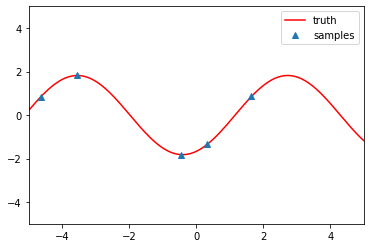

In [4]:
plot_task(batch, 0)

In [5]:
def _assign_to_tensor(tensor, value: numpy.ndarray):
    """Assign the contents of `value` to tensor."""
    with torch.no_grad():
        tensor[:] = torch.from_numpy(value)

In [37]:
class SinusoidalRegressor(torch.nn.Module):
    """A module suitable for producing  """
    
    def __init__(self, hidden_sizes: Collection[int] = (40, 40)):  
        super().__init__()
        dim_in = 1
        dim_out = 1
        all_dims = (dim_in,) + tuple(hidden_sizes) + (dim_out,)
        self.layers = [torch.nn.Linear(dim_1, dim_2) for dim_1, dim_2 in pairwise(all_dims)]
        
        for i, layer in enumerate(self.layers):
            # In the reference implementation, initialisation is:
            #    * zero for bias terms
            #    * truncated_normal, std=0.01 for weights.
            torch.nn.init.zeros_(layer.bias)
            
            # Truncated normal not available in raw pytorch, so compute the values with scipy and
            # copy into memory
            _assign_to_tensor(
                layer.weight,
                truncnorm.rvs(-2, 2, scale=0.01, size=layer.weight.shape))
            
            # Register this as a sub-module, so we declare the existence of the necessary parameters
            self.add_module(f'layer_{i}', layer)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # We should not apply the non-linearity on the last layer!
            is_last = i == len(self.layers) - 1
            if not is_last:
                x = torch.nn.functional.relu(x)
        return x
    
    def forward_with_parameter_replacement(
            self, 
            x: torch.Tensor, 
            parameter_to_replacement: Mapping[torch.nn.Parameter, torch.Tensor]):
        """Equivalent to `forward`, but using custom parameter tensors instead."""
        for i, layer in enumerate(self.layers):
            assert isinstance(layer, torch.nn.Linear)
            
            weight = old_to_new.get(layer.weight, layer.weight)
            bias = old_to_new.get(layer.bias, layer.bias)
            
            x = torch.nn.functional.linear(x, weight, bias)
            
            # We should not apply the non-linearity on the last layer!
            is_last = i == len(self.layers) - 1
            if not is_last:
                x = torch.nn.functional.relu(x)
        return x

In [7]:
def get_device():
    """Standard device on which to run computations."""
    return torch.device('cuda:1')

In [8]:
# From code:
batch_size_meta = 25

# The inner batch size. It seems to vary between plots.
# We actually generate *twice* this amount of data in total; half is used for the inner
# training loop, and the other half for inner testing.
batch_size_inner = 10

learning_rate_meta = 0.001  # Meta Adam optimizer
learning_rate_update = 0.001  # Inner Adam optimizer
num_steps_train_meta = 70000

In [9]:
@contextlib.contextmanager
def model_eval(model):
    """Enter 'evaluation mode' for the given model. """
    model.eval()  # DANGER: This *mutates* the model. It returns a reference to itself
    try:
        yield
    finally:
        model.train()

In [10]:
def _module_device(module: torch.nn.Module):
    """Find the pytorch device to which the given module is bound."""
    devices = {x.device for x in module.parameters()}
    if len(devices) != 1:
        raise ValueError(f"Found candidate devices {devices}")
    return next(iter(devices))


def _get_prediction_mse(module: torch.nn.Module, batch: Batch) -> torch.Tensor:
    """Get the MSE, as a tensor, for this module & batch."""
    device = _module_device(module)
    x = torch.tensor(batch.x.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    y = torch.tensor(batch.y.ravel(), dtype=torch.float32).unsqueeze(1).to(device)

    # Forward pass: Compute predicted y by passing x to the model
    y_pred = module(x)
    
    # Compute loss.
    return torch.nn.functional.mse_loss(y_pred, y)


def _train_step(module: torch.nn.Module, train_batch: Batch, optimizer):
    loss = _get_prediction_mse(module, train_batch)

    # Zero gradients, perform a backward pass (compute gradients wrt. the loss), and update the 
    # weights accordingly.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

def _get_prediction(module: torch.nn.Module, x: numpy.ndarray) -> numpy.ndarray:
    device = _module_device(module)
    torch_x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
    with torch.no_grad(), model_eval(module):
        torch_y = module(torch_x)
    return torch_y.cpu().numpy().squeeze(1)
    
    
class BatchPrediction(NamedTuple):
    y: numpy.ndarray
    mse_loss: float

    
def _get_test_prediction(module, test_batch: Batch) -> BatchPrediction:
    """Get the prediction when evaluating the module on the given batch."""
    device = _module_device(module)
    test_x = torch.tensor(test_batch.x.ravel(), dtype=torch.float32).unsqueeze(1).to(device)
    test_y = torch.tensor(test_batch.y.ravel(), dtype=torch.float32).unsqueeze(1).to(device)

    # No need to accumulate gradients when evaluating the validation loss.
    # Also, we put the model into "evaluation mode" for the purpose of computing the prediction.
    # This is to prevent layers like BatchNorm / Dropout mutating their internal state.
    with torch.no_grad(), model_eval(module):
        test_y_pred = module(test_x)
        test_mse = torch.nn.functional.mse_loss(test_y_pred, test_y).item()
        
    return BatchPrediction(test_y_pred.cpu().numpy().squeeze(1), test_mse)

In [11]:
def pretrain_example(
        *,
        num_steps_train: int = 70000,
        batch_size_meta: int = 25,
        batch_size_inner: int = 10,
        learning_rate: float = 0.001,
        verbose: bool = False) -> Tuple[list, torch.nn.Module]:
    device = get_device()
    module = SinusoidalRegressor().to(device)
    
    if verbose:
        print(module)

    # Construct an Optimizer. The call to model.parameters() in the constructor will contain the
    # learnable parameters of the module.
    optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
    
    # These are the MSEs from the 'test' part of the batches drawn within the meta-training process.
    meta_train_test_mses = []

    numpy.random.seed(42)
    
    with Timer() as timer:
        for i_meta in range(num_steps_train):
            
            # Generate a batch with which to train.
            batch = generate_sinusoid_batch(batch_size_meta, batch_size_inner * 2)
            
            train_batch = batch[:batch_size_inner]
            test_batch = batch[batch_size_inner:]
            
            _train_step(module, train_batch, optimizer)

            if i_meta % 500 == 0:
                prediction = _get_test_prediction(module, test_batch)
                meta_train_test_mses.append(prediction.mse_loss)
                if verbose:
                    print(f'Epoch {i_meta + 1}/{num_steps_train}:   {prediction.mse_loss}')

    print(timer)
    
    return meta_train_test_mses, module

In [12]:
meta_train_test_mses, module = pretrain_example()

83.087


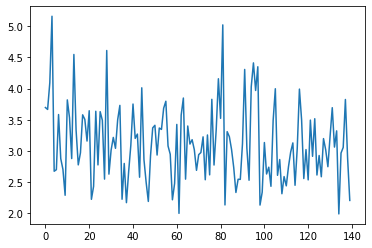

In [13]:
pyplot.plot(meta_train_test_mses)

In [14]:
def meta_test(
        module,
        *,
        batch_size_inner: int = 10,
        input_range: tuple = _DEFAULT_INPUT_RANGE,
        learning_rate: float = 0.001):
    """Perform a single test on the trained module"""
    # We need to make an independent copy of the module's parameters before we mutate them in training.
    # This seems like an incredibly blunt way of achieving this, but it seems to work.
    module = copy.deepcopy(module)
    
    # A batch of data on which we shall be testing.
    batch = generate_sinusoid_batch(1, batch_size_inner, input_range=input_range)
    test_x = numpy.linspace(_DEFAULT_INPUT_RANGE[0], _DEFAULT_INPUT_RANGE[1])
    
    y = _get_prediction(module, test_x)
    
    plot_task(batch, 0)
    pyplot.plot(test_x, y, '-', c='lightblue', ls='dotted', alpha=0.5, label='pre-update')
    
    # Now perform a small number of learning updates on the batch, plotting how our prediction evolves.
    optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate)
    
    _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c='blue', ls='dotted', alpha=0.5, label='1 grad step')
    
    for _ in range(9):
        _train_step(module, batch, optimizer)
    y = _get_prediction(module, test_x)
    pyplot.plot(test_x, y, '-', c='blue', ls='-.', alpha=0.6, label='10 grad steps')
    
#     for _ in range(10):
#         _train_step(module, batch, optimizer)
#     y = _get_prediction(module, test_x)
#     pyplot.plot(test_x, y, '-', c='darkblue', ls='dashed', alpha=0.9, label='20 grad steps')
    
    pyplot.title(f'K = {batch_size_inner}, LR = {learning_rate}')
    pyplot.legend()
    pyplot.tight_layout()

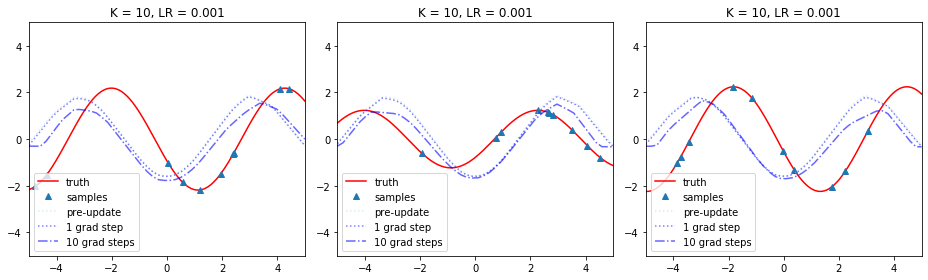

In [15]:
for _ in axes_iter(range(3)):
    meta_test(module)

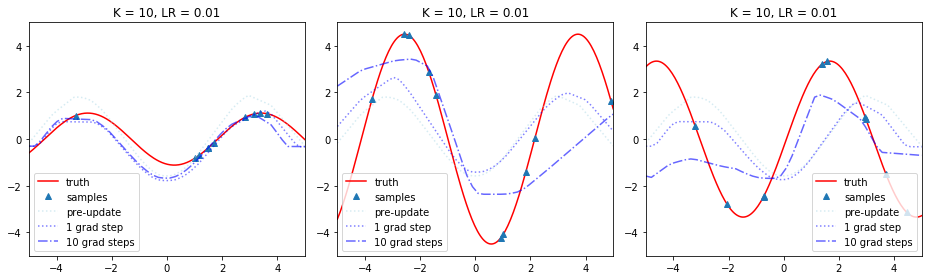

In [16]:
for _ in axes_iter(range(3)):
    meta_test(module, learning_rate=0.01)

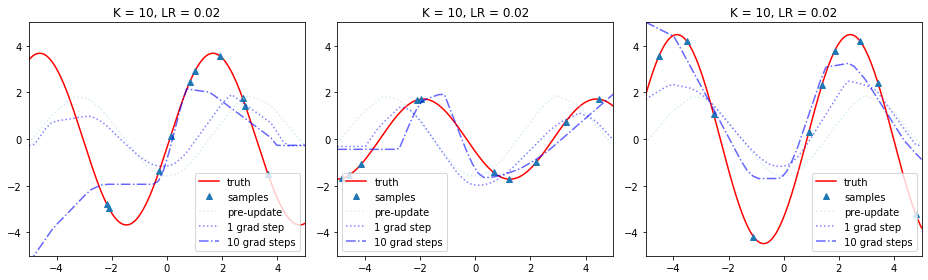

In [17]:
for _ in axes_iter(range(3)):
    meta_test(module, learning_rate=0.02)

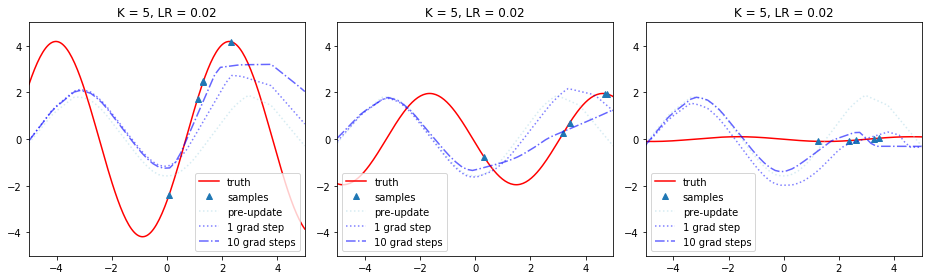

In [18]:
for _ in axes_iter(range(3)):
    meta_test(module, batch_size_inner=5, input_range=(0, 5), learning_rate=0.02)

In [38]:
def maml_train(
        *,
        num_steps_meta: int = 10, #70000,
        num_steps_inner: int = 1,
        batch_size_meta: int = 25,
        batch_size_inner: int = 10,
        learning_rate_meta: float = 0.001,  # Meta Adam optimizer
        learning_rate_inner: float = 0.001,  # Inner Adam optimizer
        verbose: bool = False) -> Tuple[list, torch.nn.Module]:
    device = get_device()
    module = SinusoidalRegressor().to(device)
    
    if verbose:
        print(module)

    # Construct an Optimizer. The call to model.parameters() in the constructor will contain the
    # learnable parameters of the module.
    meta_optimizer = torch.optim.Adam(module.parameters(), lr=learning_rate_meta)
    
    # These are the MSEs from the 'test' part of the batches drawn within the meta-training process.
    meta_train_test_mses = []

    numpy.random.seed(42)  # FIXME This shouldn't live here.
    
    with Timer() as timer:
        for i_meta in range(num_steps_meta):
            
            # Generate a batch with which to train.
            batch = generate_sinusoid_batch(batch_size_meta, batch_size_inner * 2)
            
            train_batch = batch[:batch_size_inner]
            test_batch = batch[batch_size_inner:]
            
            total_losses = []
            for i_task in range(batch_size_meta):
                # TODO
                # 1. Forward on the original module
                # 2. Backward on the resulting loss - use gradients to build *new* parameters
                # 3. Forward with new parameters to build loss used in meta-train step.
                
                # Q - step 3 uses params of the form \theta' = \theta - \lambda \nabla_\theta (loss). When
                #   we then come to do a backward pass on a loss generated therefrom, will the gradient retain
                #   its relationship to \theta? This is required for the second-order effect.
                
                # For each task we are going to get a version of the module that is tuned
                # to this particular task.
                tuned_module = copy.deepcopy(module)

                # Run `num_steps_inner` steps of fine-tuning for this module.
                task_train_batch = train_batch.for_task(i_task)
                # TODO inner optimisation should just be vanilla gradient descent to match the paper.
                inner_optimizer = torch.optim.Adam(tuned_module.parameters(), lr=learning_rate_inner)
                for _ in range(num_steps_inner):
                    _train_step(
                        tuned_module,
                        train_batch,
                        inner_optimizer)
                
                # Now evaluate the loss.
                task_test_batch = test_batch.for_task(i_task)
                total_losses.append(_get_prediction_mse(tuned_module, task_test_batch))
            
            # Whilst the paper uses a sum, in practice the reference implementation uses a mean.
            total_loss = sum(total_losses) / batch_size_meta

            # FIXME It looks like no updates are actually getting applied - so either the gradients
            # are zero or there is an error in persistence for some reason. Maybe it is due to the deepcopy?
            meta_optimizer.zero_grad()
            total_loss.backward()
            meta_optimizer.step()
            
            if i_meta % 500 == 0:
                prediction = _get_test_prediction(module, test_batch)
                meta_train_test_mses.append(prediction.mse_loss)
                if verbose:
                    print(f'Epoch {i_meta + 1}/{num_steps_meta}:   {prediction.mse_loss}')

    print(timer)
    
    return meta_train_test_mses, module

In [90]:
x = torch.ones(1, requires_grad=True)
y = x * x * x

# create_graph=True is required for allowing higher-order derivatives. Note that we
# get the wrong answer below if we set it to False!

# NB - we *may* in practice want to experiment with setting this to False, though. Effectively this will
# drop second-order terms when we come to perform the meta-training step.
z = torch.autograd.grad([y], [x], create_graph=True)[0]
w = x + z
print(z)
print(torch.autograd.grad(w, x))

tensor([3.], grad_fn=<AddBackward0>)
(tensor([7.]),)


In [218]:
meta_train_test_mses_maml, module_maml = maml_train(verbose=True)

SinusoidalRegressor(
  (layer_0): Linear(in_features=1, out_features=40, bias=True)
  (layer_1): Linear(in_features=40, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch 1/70000:   3.6963951587677
Epoch 501/70000:   4.351430892944336
Epoch 1001/70000:   5.247311115264893
Epoch 1501/70000:   5.535463809967041
Epoch 2001/70000:   3.3960399627685547
Epoch 2501/70000:   3.2216038703918457
Epoch 3001/70000:   4.462289333343506
Epoch 3501/70000:   4.411314010620117
Epoch 4001/70000:   3.946359872817993
Epoch 4501/70000:   2.7638604640960693
Epoch 5001/70000:   4.9201836585998535
Epoch 5501/70000:   5.388440132141113
Epoch 6001/70000:   5.24320650100708
Epoch 6501/70000:   6.053046226501465
Epoch 7001/70000:   4.459823131561279
Epoch 7501/70000:   4.005901336669922
Epoch 8001/70000:   3.2724950313568115
Epoch 8501/70000:   4.462460994720459
Epoch 9001/70000:   4.926517963409424
Epoch 9501/70000:   4.525813579559326
Epoch 10001/

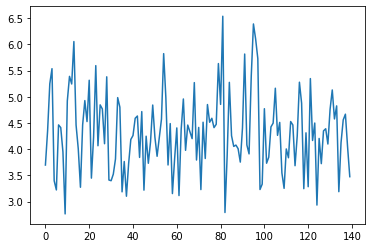

In [219]:
pyplot.plot(meta_train_test_mses_maml)

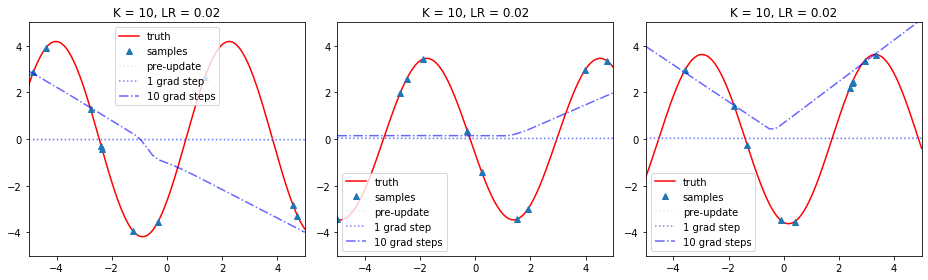

In [223]:
for _ in axes_iter(range(3)):
    meta_test(module_maml, learning_rate=0.02)

(array([1., 2., 4., 3., 2., 7., 4., 6., 5., 6.]),
 array([-0.01793199, -0.01479476, -0.01165752, -0.00852029, -0.00538305,
        -0.00224582,  0.00089142,  0.00402865,  0.00716589,  0.01030312,
         0.01344036], dtype=float32),
 <a list of 10 Patch objects>)

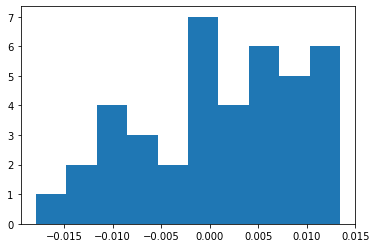

In [233]:
pyplot.hist(module_maml.layer_0.weight.data.cpu().numpy().ravel())

(array([ 51., 111., 151., 225., 245., 256., 241., 165.,  90.,  65.]),
 array([-1.9998509e-02, -1.6003624e-02, -1.2008739e-02, -8.0138538e-03,
        -4.0189684e-03, -2.4083070e-05,  3.9708023e-03,  7.9656877e-03,
         1.1960573e-02,  1.5955457e-02,  1.9950343e-02], dtype=float32),
 <a list of 10 Patch objects>)

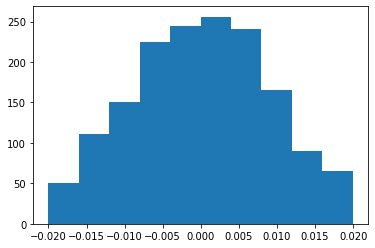

In [232]:
pyplot.hist(module_maml.layer_1.weight.data.cpu().numpy().ravel())

(array([2., 1., 3., 5., 7., 4., 6., 4., 6., 2.]),
 array([-0.01805391, -0.01470057, -0.01134722, -0.00799388, -0.00464054,
        -0.0012872 ,  0.00206614,  0.00541948,  0.00877282,  0.01212616,
         0.0154795 ], dtype=float32),
 <a list of 10 Patch objects>)

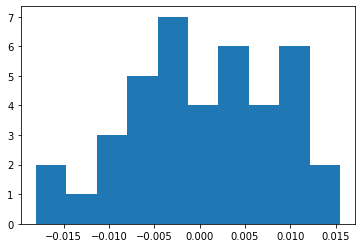

In [234]:
pyplot.hist(module_maml.layer_2.weight.data.cpu().numpy().ravel())

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 10 Patch objects>)

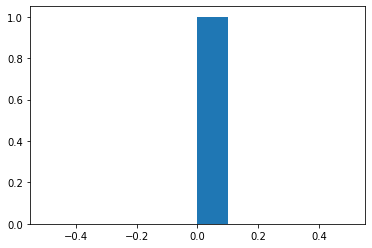

In [237]:
pyplot.hist(module_maml.layer_2.bias.data.cpu().numpy().ravel())

In [269]:
# Hmm- we basically want to be able to start with the original module, then perform a gradient update
# *into a new module*, whose parameters depend on the original such that autograd can keep track.
hack_module = copy.deepcopy(module)
hack_module.layer_0.bias = torch.nn.Parameter(module.layer_0.bias + 1)

In [270]:
module.layer_0.bias.grad.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:1')

In [271]:
print(hack_module.layer_0.bias.grad)

None


In [303]:
(1 + hack_module.layer_0.bias).grad_fn.next_functions[0][0].variable

Parameter containing:
tensor([0.9551, 0.3408, 0.9551, 0.9889, 0.8719, 0.5502, 0.9217, 0.9217, 0.8790,
        0.2869, 0.9339, 0.6958, 0.4014, 0.8248, 0.9629, 0.9573, 0.9847, 0.8580,
        0.9215, 0.8620, 0.9697, 0.8266, 0.8561, 0.7556, 0.9705, 0.9191, 0.4818,
        0.8073, 0.8691, 0.9279, 0.9766, 0.9299, 0.7396, 0.6189, 0.8428, 0.3325,
        0.3451, 0.9102, 0.6421, 0.8322], device='cuda:1', requires_grad=True)

In [286]:
hack_module.layer_0.bias

Parameter containing:
tensor([0.9551, 0.3408, 0.9551, 0.9889, 0.8719, 0.5502, 0.9217, 0.9217, 0.8790,
        0.2869, 0.9339, 0.6958, 0.4014, 0.8248, 0.9629, 0.9573, 0.9847, 0.8580,
        0.9215, 0.8620, 0.9697, 0.8266, 0.8561, 0.7556, 0.9705, 0.9191, 0.4818,
        0.8073, 0.8691, 0.9279, 0.9766, 0.9299, 0.7396, 0.6189, 0.8428, 0.3325,
        0.3451, 0.9102, 0.6421, 0.8322], device='cuda:1', requires_grad=True)

In [272]:
sum(hack_module.layer_0.bias).backward()

In [273]:
print(hack_module.layer_0.bias.grad)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], device='cuda:1')


In [275]:
module.layer_0.bias.grad

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:1')

In [22]:
hack_module = copy.deepcopy(module)
hack_module.layer_0.weight = module.layer_0.weight + 1

TypeError: cannot assign 'torch.cuda.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [30]:
{module.layer_0.weight: 1}

{Parameter containing:
 tensor([[-0.1681],
         [-0.1615],
         [ 0.1812],
         [-0.2105],
         [-0.1448],
         [ 0.1669],
         [ 0.1752],
         [ 0.1975],
         [ 0.0953],
         [-0.2209],
         [-0.1828],
         [ 0.1895],
         [ 0.1695],
         [-0.0765],
         [ 0.1571],
         [ 0.0710],
         [ 0.1285],
         [ 0.1864],
         [-0.1366],
         [-0.1834],
         [-0.0371],
         [ 0.1741],
         [-0.1910],
         [ 0.1091],
         [ 0.1520],
         [ 0.1767],
         [ 0.1380],
         [-0.2047],
         [-0.1559],
         [ 0.1676],
         [-0.1411],
         [-0.1898],
         [ 0.1362],
         [-0.0004],
         [-0.1608],
         [-0.2183],
         [-0.1938],
         [-0.1243],
         [-0.0797],
         [ 0.1985]], device='cuda:1', requires_grad=True): 1}

In [25]:
x = torch.nn.Parameter.__new__(torch.nn.Parameter, module.layer_0.weight + 1)

In [27]:
(module.layer_0.weight + 1).grad_fn

In [307]:
list(module.named_parameters())

[('layer_0.weight',
  Parameter containing:
  tensor([[-1.6665e-01],
          [-1.6132e-01],
          [ 1.9405e-01],
          [-1.3592e-04],
          [ 1.7772e-01],
          [ 1.1539e-01],
          [-2.1000e-01],
          [ 1.6432e-01],
          [ 1.8491e-01],
          [-1.9820e-01],
          [ 9.7805e-02],
          [-6.0381e-02],
          [ 1.5337e-01],
          [ 1.8509e-01],
          [-1.6305e-01],
          [-1.2509e-01],
          [ 1.9421e-03],
          [-1.3655e-01],
          [-1.1922e-01],
          [-1.1555e-01],
          [ 1.2919e-01],
          [ 1.5605e-01],
          [ 1.5191e-01],
          [-4.8701e-02],
          [-2.1981e-01],
          [-1.3760e-01],
          [ 1.3297e-01],
          [-1.7666e-01],
          [-1.8463e-01],
          [ 1.7974e-01],
          [ 2.2102e-01],
          [-1.5865e-01],
          [-5.1269e-02],
          [-1.8338e-01],
          [-1.5833e-01],
          [-1.6914e-01],
          [ 1.7587e-01],
          [ 1.5035e-01],
      